In [1]:
import os
import numpy as np
import pickle
from runwise_ts_log_data import get_ts_log_data_blocked
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# model identifiers
num_states = 5
latent_dim = 10
num_rois = 100
num_subjs = 30

state_names = ['far','post-shock','approach','touch','retreat'] # 30 part 5 state

# load dataset
df = get_ts_log_data_blocked(num_subjects=num_subjs)
subj_list = df.pid.unique()

# load model
with open(f'pkl/rslds_K{num_states}_D{latent_dim}_N{num_rois}_{num_subjs}subjs_emoprox.pkl','rb') as f:
    model, q, elbos = pickle.load(f)

0it [00:00, ?it/s]

In [3]:
df['continuous_states'] = [None]*df.shape[0]
df['discrete_states'] =[None]*df.shape[0]
for idx_row in range(df.shape[0]):
    y = df.loc[idx_row]['timeseries']
    x = q.mean_continuous_states[idx_row]
    z = model.most_likely_states(x,y)
    df.at[idx_row,'continuous_states'] = x
    df.at[idx_row,'discrete_states'] = z
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df.at[idx_row,'proximity'] = prox
print(df.columns)

Index(['pid', 'rid', 'block', 'timeseries', 'proximity', 'direction', 'speed',
       'time', 'proximity_hrf', 'direction_hrf', 'speed_hrf', 'censor',
       'block_mask', 'continuous_states', 'discrete_states'],
      dtype='object')


In [69]:
# ROI names and network labels for Schaefer 100 ROI atlas
atlas_df = pd.read_csv('https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/freeview_lut/Schaefer2018_100Parcels_17Networks_order.txt',sep='\t',header=None)
atlas_df = atlas_df[[0,1]]
atlas_df.columns = ['idx','name']
atlas_df['name'] = atlas_df['name'].apply(lambda s: s[11:].split('_'))
atlas_df['hemi'] = atlas_df['name'].apply(lambda s: s[0])
atlas_df['network'] = atlas_df['name'].apply(lambda s: s[1])
atlas_df['name'] = atlas_df['name'].apply(lambda s: '_'.join(s[2:]))
atlas_df['idx'] = atlas_df['idx'] - 1

network_names = atlas_df['network'].unique()
num_networks = len(network_names)

network_names_najafi = ['DorsAttnA','DorsAttnB','SalVentAttnA','SalVentAttnB','DefaultA','DefaultB','DefaultC']

net_idx = []
net_idx_najafi = []
for i, net in enumerate(network_names): 
    indices = atlas_df[atlas_df['network']==net]['idx'].values
    if net in network_names_najafi:
        net_idx_najafi.append(indices)
    net_idx.append(indices)
net_idx = np.hstack(net_idx)
net_idx_najafi = np.hstack(net_idx_najafi)

In [5]:
prox_bins = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
dir_bins = [0]
hrf_shift = 3

with open('pkl/rslds_K{num_states}_D{latent_dim}_N{num_rois}_{num_subjs}subjs_emoprox_state_stim_assoc.pkl','rb') as f:
    [true_count_mats, p_vals] = pickle.load(f)

In [6]:
df['significant_states'] = [None]*df.shape[0]
for idx_row in range(df.shape[0]):
    states = df.loc[idx_row]['discrete_states']
    prox = np.digitize(df.loc[idx_row]['proximity'], bins=prox_bins)
    dir = np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
    prox = np.roll(prox,shift=hrf_shift)[hrf_shift:]
    dir = np.roll(dir,shift=hrf_shift)[hrf_shift:]
    significant_states = -1*np.ones_like(states)
    states = states[hrf_shift:]
    for i,st,p,d in zip(range(hrf_shift,hrf_shift+len(states)),states,prox,dir):
        if p_vals[st][p,d]<0.05/40: significant_states[i] = st
        # else: significant_states[i] = st
    df.at[idx_row,'significant_states'] = significant_states

[  0   7  13  19  27  33  40  49  54  56  59  65  70  75  82  92  96 100]


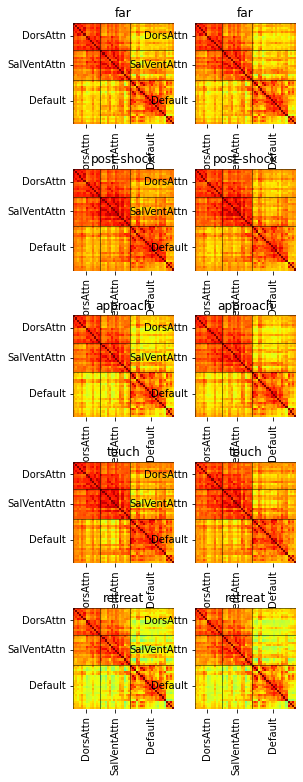

In [108]:
y_concat = np.vstack(list(df['timeseries'].values)).T
z_concat = np.hstack(list(df['discrete_states'].values))
z_concat_sign = np.hstack(list(df['significant_states'].values))

network_sizes = [(atlas_df['network'].values==name).sum() for name in network_names]
network_sizes = np.array([0]+list(np.cumsum(network_sizes)))
print(network_sizes)

network_sizesn = [(atlas_df['network'].values==name).sum() for name in network_names_najafi]
network_sizesn = [network_sizesn[0]+network_sizesn[1],network_sizesn[2]+network_sizesn[3],network_sizesn[4]+network_sizesn[5]+network_sizesn[6]]
network_sizesn = np.array([0]+list(np.cumsum(network_sizesn)))
network_namesn = ['DorsAttn','SalVentAttn','Default']

def plotfc(ax,fc,title,vmin,vmax):
    sns.heatmap(
        fc,
        ax=ax,
        cmap='jet',
        square=True,
        cbar=False,
        vmin=vmin,vmax=vmax,
        )
    ax.set_xticks((network_sizesn[1:]+network_sizesn[:-1])//2,labels=network_namesn,rotation=90)
    ax.set_yticks((network_sizesn[1:]+network_sizesn[:-1])//2,labels=network_namesn,rotation=0)
    ax.vlines(x=network_sizesn,ymin=0,ymax=num_rois,color='k',linewidth=0.5)
    ax.hlines(y=network_sizesn,xmin=0,xmax=num_rois,color='k',linewidth=0.5)
    ax.set_title(title)

fc_all = np.zeros((num_states,len(net_idx_najafi),len(net_idx_najafi)))
fc_all_sign = np.zeros((num_states,len(net_idx_najafi),len(net_idx_najafi)))

# visualize all the FC matrices
fig,axs = plt.subplots(nrows=num_states,ncols=2,figsize=(4,13))
for idx_state in range(num_states):
    for j in range(2):
        # corrcoef matrix is always according to first dimension of the timeseries matrix
        ax = axs[idx_state][j] 
        if j==0:
            fc = np.corrcoef(y_concat[:,z_concat==idx_state]) 
        else:
            fc = np.corrcoef(y_concat[:,z_concat_sign==idx_state]) 
        fc = fc[net_idx_najafi,:]
        fc = fc[:,net_idx_najafi]
        if j==0:
            fc_all[idx_state] = fc
        else:
            fc_all_sign[idx_state] = fc
        plotfc(ax,fc,state_names[idx_state],-1,1)
    
    



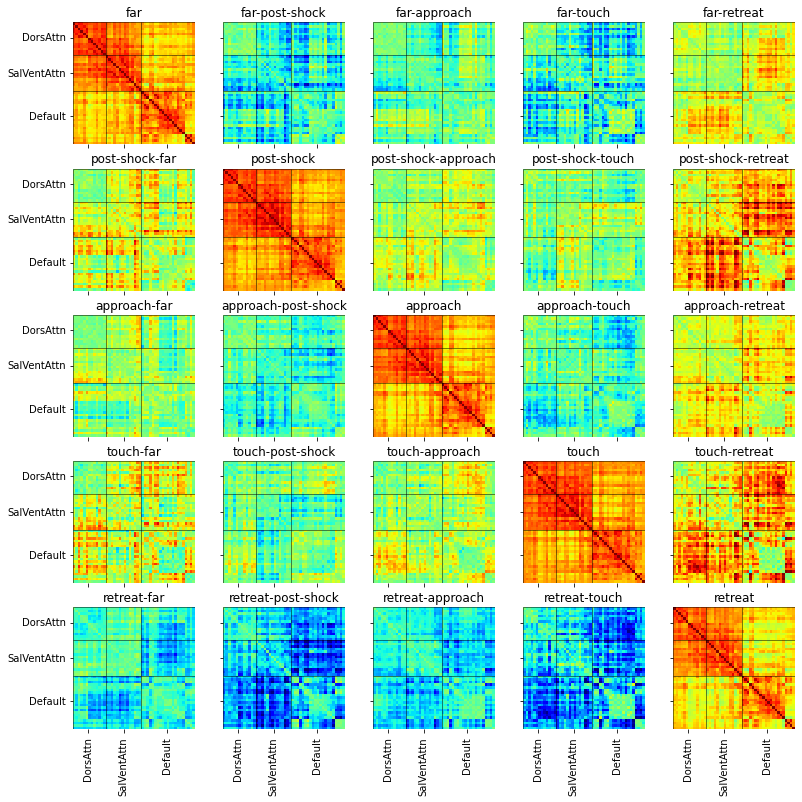

In [111]:
fig,axs = plt.subplots(nrows=num_states,ncols=num_states,figsize=(13,13),sharex=True,sharey=True)
for i in range(num_states):
    for j in range(num_states):
        ax = axs[i][j]
        if i==j:
            mat = fc_all_sign[i]
            title = f'{state_names[i]}'
            vmin,vmax = -1,1
        else:
            mat = fc_all_sign[i] - fc_all_sign[j]
            title = f'{state_names[i]}-{state_names[j]}'
            vmin,vmax = -0.3,0.3
        plotfc(ax,mat,title,vmin,vmax)
            

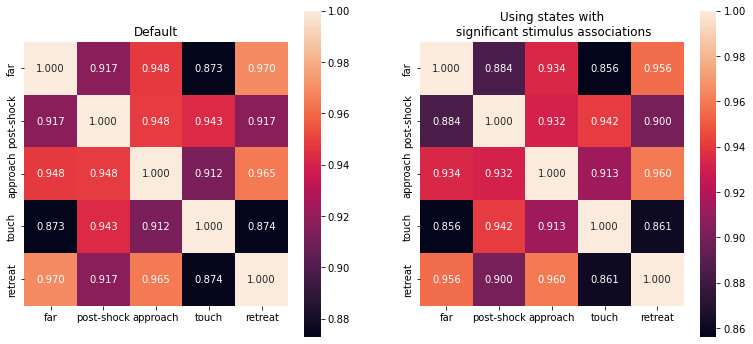

In [99]:
fc_sim = np.zeros((num_states,num_states))
fc_sim_sign = np.zeros((num_states,num_states))
for i in range(num_states):
    for j in range(num_states):
        fc1 = fc_all[i][np.triu_indices(fc_all[i].shape[0],k=1)]
        fc2 = fc_all[j][np.triu_indices(fc_all[j].shape[0],k=1)]
        fc_sim[i,j] = np.corrcoef(fc1,fc2)[0,1]

        fc1 = fc_all_sign[i][np.triu_indices(fc_all_sign[i].shape[0],k=1)]
        fc2 = fc_all_sign[j][np.triu_indices(fc_all_sign[j].shape[0],k=1)]
        fc_sim_sign[i,j] = np.corrcoef(fc1,fc2)[0,1]

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
for i in range(2):
    if i==0: mat = fc_sim
    else: mat = fc_sim_sign
    sns.heatmap(
        mat,
        annot=mat,
        fmt='.03f',
        # cmap='',
        # vmin=-1,vmax=1,
        xticklabels=state_names,
        yticklabels=state_names,
        square=True,
        ax=axs[i]
    )
    if i==0: axs[i].set_title('Default')
    else: axs[i].set_title('Using states with\n significant stimulus associations')

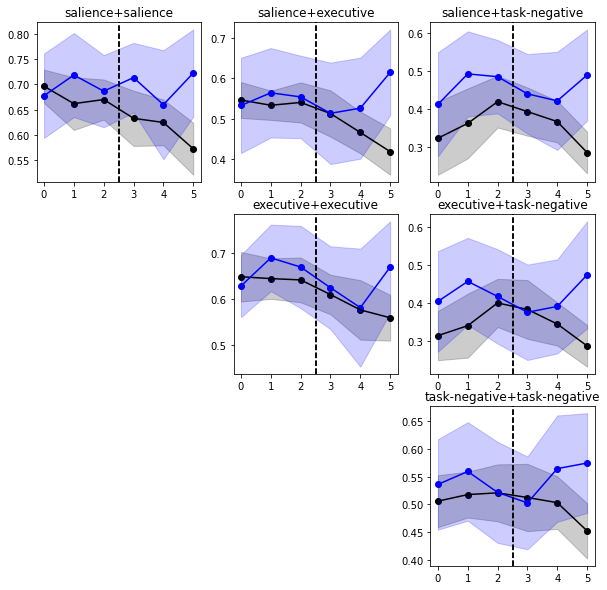

In [74]:
def get_transition_fcs(y,z,st_i,st_j,win=6):
    ret = []
    for t in range(win//2-1,len(z)-win//2):
        if z[t]==st_i and z[t+1]==st_j:
            if np.all(z[t-win//2+1:t+1]==st_i) and np.all(z[t+1:t+win//2+1]==st_j):
                ret.append(y[t-win//2+1:t+win//2+1])
    # print(len(ret))
    if len(ret)>0: 
        timepoints = np.stack(ret,axis=0)
        fcs = np.zeros((win,num_rois,num_rois))
        for t in range(win):
            fcs[t] = np.corrcoef(timepoints[:,t,:].squeeze().T)
        return fcs
    else: return None

def get_mean_transition_response(state_from,state_to):
    subj_list = df.pid.unique()
    trans_fcs = []
    for pid in subj_list:
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.vstack(list(df_subj.timeseries.values))
        dfc_trans = get_transition_fcs(y_subj,z_subj,state_from,state_to)
        if dfc_trans is not None: 
            trans_fcs.append(dfc_trans)
    trans_fcs = np.stack(trans_fcs,axis=0)
    return trans_fcs

win=6
trans_fcs = {}
trans_colors = {'40':'green','42':'red','24':'black','23':'blue'}
trans_fcs['40'] = get_mean_transition_response(4,0)
trans_fcs['24'] = get_mean_transition_response(2,4)
trans_fcs['23'] = get_mean_transition_response(2,3)
trans_fcs['42'] = get_mean_transition_response(4,2)

# print(trans_fcs.shape)

network_indices = {}
network_indices['salience'] = atlas_df[atlas_df.network.isin(['SalVentAttnA','SalVentAttnB'])].idx.values
network_indices['executive'] = atlas_df[atlas_df.network.isin(['DorsAttnA','DorsAttnB'])].idx.values
network_indices['task-negative'] = atlas_df[atlas_df.network.isin(['DefaultA','DefaultB','DefaultC'])].idx.values
najafi_nets = ['salience','executive','task-negative']

def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96
def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
            ret[i] = bootstrap_err(X[:,i])
    return ret

fig,axs = plt.subplots(nrows=len(najafi_nets),ncols=len(najafi_nets),figsize=(10,10))
for idx_trans in ['24','23']:
    for i, net_i in enumerate(najafi_nets):
        for j, net_j in enumerate(najafi_nets):
            if i>j: 
                axs[i][j].set_axis_off()
                continue
            ax = axs[i][j]
            fc_ts = trans_fcs[idx_trans][:,:,network_indices[net_i],:]
            fc_ts = fc_ts[:,:,:,network_indices[net_j]]
            fc_ts = fc_ts.mean(axis=-1).mean(axis=-1)
            mean_ts = fc_ts.mean(axis=0)
            std_ts = bootstrap_err_matrix(fc_ts)
            ax.plot(mean_ts,color=trans_colors[idx_trans])
            ax.scatter(np.arange(win),mean_ts,color=trans_colors[idx_trans])
            ax.fill_between(np.arange(win),mean_ts-std_ts,mean_ts+std_ts,alpha=0.2,color=trans_colors[idx_trans])
            ax.set_title(f'{net_i}+{net_j}')
            ax.axvline(x=win/2-0.5,color='k',linestyle='--')
            ax.set_xticks(np.arange(win),labels=np.arange(win))
            # print(mean_ts.shape)
            # print(net_i,net_j,fc_ts.shape)



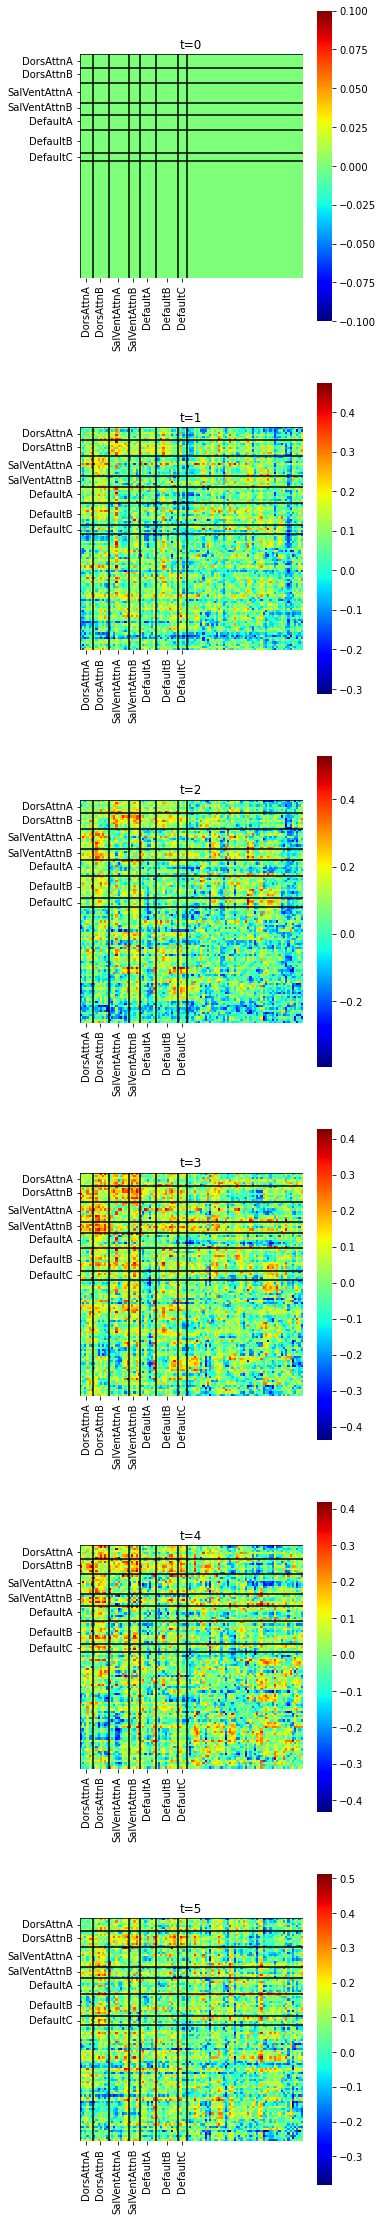

In [76]:
mean_trans_fcs = trans_fcs['23'].mean(axis=0)
mean_trans_fcs = mean_trans_fcs[:,net_idx,:]
mean_trans_fcs = mean_trans_fcs[:,:,net_idx]
fig,axs = plt.subplots(nrows=win,ncols=1,figsize=(5,40))
for i in range(mean_trans_fcs.shape[0]):
    ax=axs[i]
    sns.heatmap(
        mean_trans_fcs[i]-mean_trans_fcs[0],
        ax=ax,
        cmap='jet',
        square=True,
        cbar=True,
        # vmin=-0.3,vmax=0.3,
        )
    ax.set_xticks((network_sizes[1:]+network_sizes[:-1])//2,labels=network_names_najafi,rotation=90)
    ax.set_yticks((network_sizes[1:]+network_sizes[:-1])//2,labels=network_names_najafi)
    ax.vlines(x=network_sizes,ymin=0,ymax=num_rois,color='k')
    ax.hlines(y=network_sizes,xmin=0,xmax=num_rois,color='k')
    ax.set_title(f't={i}')